**여러 차원 축소 기법을 탐구 및 적용하여 데이터를 시각화하고 시각적 패턴을 감지한다.**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장 {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA
3D 데이터셋을 만든다:

In [2]:
import numpy as np

m = 60
w1, w2 = 0.1, 0.3
noise = 0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## 주성분

$X = U \sum V^T$ 에서 $V$가 주성분

* (m, m) (m, n) (n, n)

m: 샘플 개수, n: 특성 개수

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## d 차원으로 투영하기

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

## 사이킷런 사용하기

사이킷런에서는 PCA가 아주 간단하다. 데이터셋에서 평균을 빼는 작업도 대신 처리해 준다:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[-0.25259686,  0.67323824],
       [-0.85407481,  0.07695285],
       [ 1.26469413, -0.02009658],
       [-0.42834096, -0.34642426],
       [ 1.54122807,  0.58289464]])

In [10]:
X2D_using_svd[:5]

array([[-0.25259686, -0.67323824],
       [-0.85407481, -0.07695285],
       [ 1.26469413,  0.02009658],
       [-0.42834096,  0.34642426],
       [ 1.54122807, -0.58289464]])

데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라질 것이다. 일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도이다. 이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만든다:

In [11]:
np.allclose(abs(X2D), abs(X2D_using_svd))

True

평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원한다.

In [12]:
X3D_inv = pca.inverse_transform(X2D)

물론, 투영 단게에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않다:

In [13]:
np.allclose(X3D_inv, X)

False

재구성 오차를 계산한다:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.0075493617941435305

SVD 방식의 역변환은 다음과 같다:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 `PCA` 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않다. 하지만 평균을 빼면 동일한 재구성을 얻을 수 있다:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

`PCA` 객체를 사용하여 계산된 주성분을 참조할 수 있다:

In [17]:
pca.components_

array([[-0.97672664, -0.14589534, -0.15722474],
       [ 0.18285778, -0.94953207, -0.25485658]])

SVD 방법으로 계산된 처음 두 개의 주성분과 비교해 보겠다:

In [18]:
Vt[:2]

array([[-0.97672664, -0.14589534, -0.15722474],
       [-0.18285778,  0.94953207,  0.25485658]])

축이 다른 것을 알 수 있다.

## 설명된 분산의 비율

이제 설명된 분산 비율을 확인해 보겠다:

In [19]:
pca.explained_variance_ratio_

array([0.86396727, 0.12685118])

첫 번째 차원과 두 번째 차원의 분산 비율을 설명한다.

2D로 투영했기 때문에 분산의 극히 일부를 잃었다:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.009181552245462021

SVD 방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법은 다음과 같다(`s`는 행렬 `S`의 대각 성분이다):

In [21]:
np.square(s) / np.square(s).sum()

array([0.86396727, 0.12685118, 0.00918155])

이를 그래프로 멋지게 그려 보자! :)

**<2차원에 가깝게 배치된 3차원 데이터셋>**

3D 화살표를 그리기 위한 유틸리티 클래스이다(http://stackoverflow.com/questions/11140163 에서 복사했다)

In [22]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

x와 y의 함수로 평면을 표현한다.

In [23]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]
x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)
C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

3D 데이터셋, 평면 그리고 이 평면으로의 투영을 그린다.

그림 저장 dataset_3d_plot


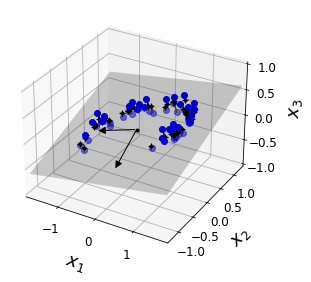

In [24]:
fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection="3d")
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)
ax.plot_surface(x1, x2, z, alpha=0.2, color='k')
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]], [0, C[0, 1]], [0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color='k'))
ax.add_artist(Arrow3D([0, C[1, 0]], [0, C[1, 1]], [0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color='k'))
ax.plot([0], [0], [0], "k.")
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
        pass
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], '-', color="#505050")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("dataset_3d_plot")
plt.show()

**<투영하여 만들어진 새로운 2D 데이터셋>**

그림 저장 dataset_2d_plot


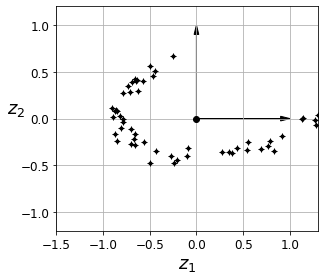

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

**<스위스롤 데이터셋>**

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2)

그림 저장 swiss_roll_plot


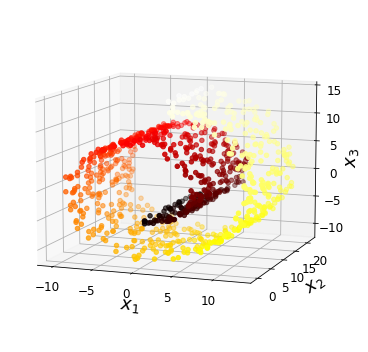

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("swiss_roll_plot")
plt.show()

**<평면에 그냥 투영시켜서 뭉개진 것(왼쪽)과 스위스 롤을 펼쳐 놓은 것(오른쪽)>**

그림 저장 squished_swiss_roll_plot


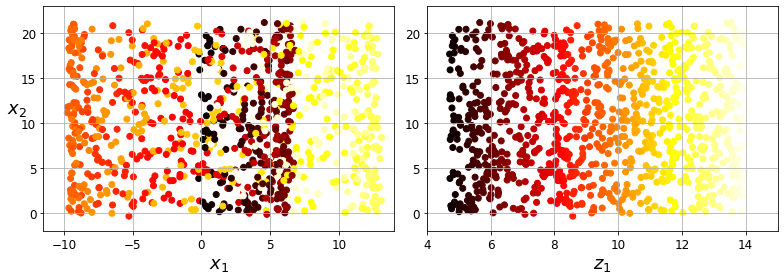

In [28]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
save_fig("squished_swiss_roll_plot")
plt.show()

**<저차원에서 항상 간단하지 않은 결정 경계>**

그림 저장 manifold_decision_boundary_plot1


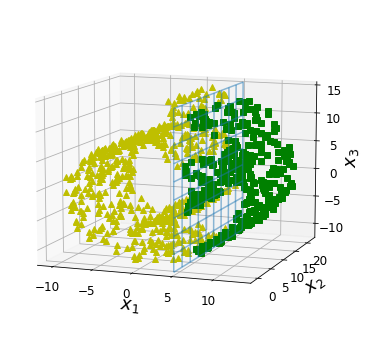

그림 저장 manifold_decision_boundary_plot2


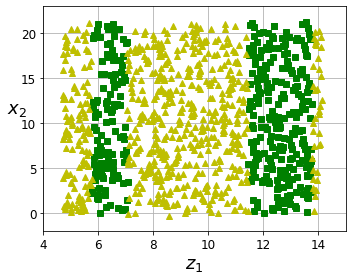

그림 저장 manifold_decision_boundary_plot3


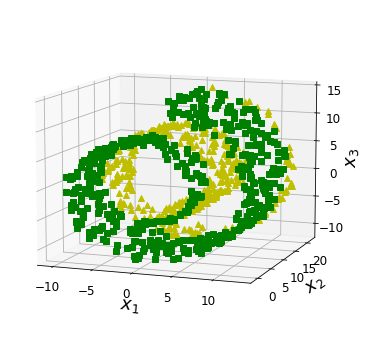

그림 저장 manifold_decision_boundary_plot4


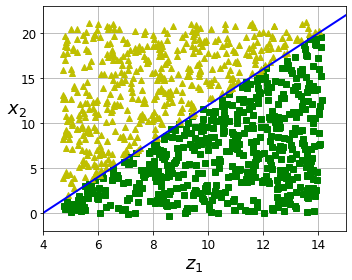

In [29]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)
plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection="3d")
positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot1")
plt.show()
plt.figure(figsize=(5, 4))
plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()
plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection="3d")
positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()
plt.figure(figsize=(5, 4))
plt.subplot(111)
plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

**<투영할 부분 공간 선택하기>**

그림 저장 pca_best_projection_plot


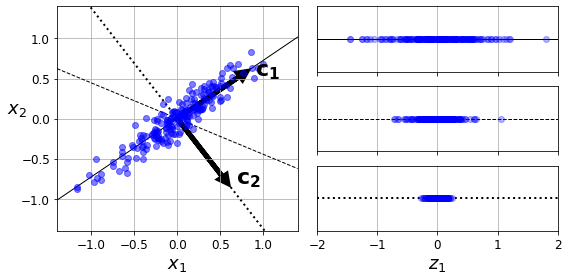

In [30]:
angle = np.pi / 5
stretch = 5
m = 200
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]]))  # 뻗기
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])  # 회전
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))
plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)
plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)
plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
save_fig("pca_best_projection_plot")
plt.show()

## 적절한 차원수 선택하기

In [31]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [32]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [33]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

**<차원 수에 대한 함수로 나타낸 설명된 분산>**

그림 저장 explained_variance_plot


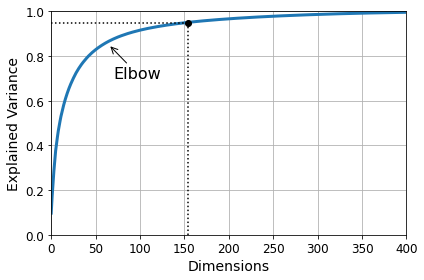

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [36]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:
pca.n_components_

154

In [38]:
np.sum(pca.explained_variance_ratio_)

0.9504113270523677

## 압축을 위한 PCA

In [39]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

**<분산의 95%가 유지된 MNIST 압축>**

In [40]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일하다:
    n_rows = (len(instances) - 1) // images_per_row + 1
    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가한다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성한다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합친다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합친다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 된다:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 mnist_compression_plot


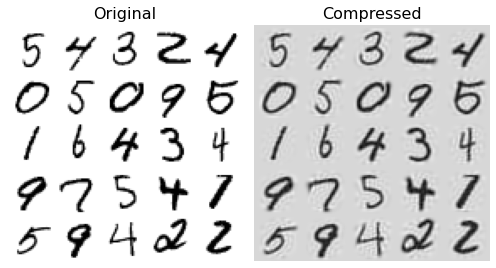

In [41]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
save_fig("mnist_compression_plot")

In [42]:
X_reduced_pca = X_reduced

## 랜덤 PCA

In [43]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## 점진적 PCA

In [44]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print('.', end='')
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [45]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

압축이 잘 되었는지 확인해 보자:

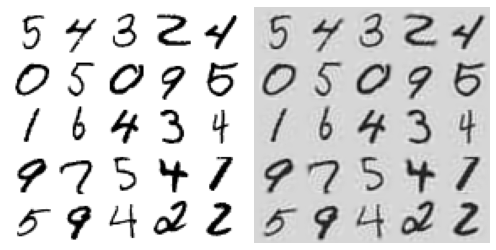

In [46]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [47]:
X_reduced_inc_pca = X_reduced

일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과를 비교해 보겠다. 먼저 평균이 같은지 확인한다: 

In [48]:
np.allclose(pca.mean_, inc_pca.mean_)

True

하지만 결과는 완전히 동일하지 않다. 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않다:

In [49]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

**`memmap()` 사용하기**

`memmap()` 구조를 만들고 MNIST 데이터를 복사한다. 이는 일반적으로 별도의 프로그램에서 먼저 수행된다:

In [50]:
filename = "my_mnist.data"
m, n = X_train.shape
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train

이제 데이터가 디스크에 저장되었는지 확인하기 위해 `memmap()` 객체를 삭제한다.

In [51]:
del X_mm

다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용한다:

In [52]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**시간 복잡도**

주성분 개수를 바꾸어가며 점진적 PCA와 랜덤 PCA에 비해 일반 PCA 시간을 재어 본다:

In [53]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

In [54]:
import time

for n_components in (2, 10, 154):
    print(f"n_components = {n_components}")
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, svd_solver="randomized")
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train[::2])
        t2 = time.time()
        print(f"    {pca.__class__.__name__}: {t2 - t1:.1f} 초")

n_components = 2
    PCA: 2.6 초
    IncrementalPCA: 11.8 초
    PCA: 0.7 초
n_components = 10
    PCA: 2.4 초
    IncrementalPCA: 11.8 초
    PCA: 0.7 초
n_components = 154
    PCA: 2.4 초
    IncrementalPCA: 14.8 초
    PCA: 1.6 초


이번에는 데이터셋의 크기(샘플의 수)를 바꾸어 가며 일반 PCA와 랜덤 PCA를 비교해 보겠다:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

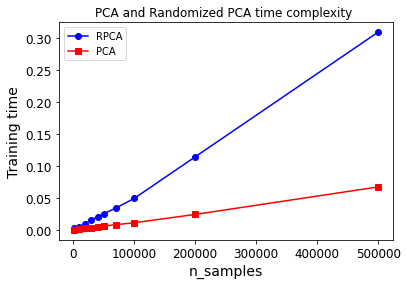

In [55]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

이번에는 특성의 개수를 달리하면서 2,000 샘플이 있는 데이터셋에서 성능을 비교해 보겠다:

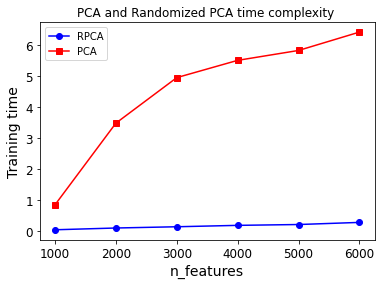

In [56]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")
plt.show()

# 커널 PCA

In [57]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

In [58]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, n_jobs=-1)
X_reduced = rbf_pca.fit_transform(X)

**<여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤>**

그림 저장 kernel_pca_plot


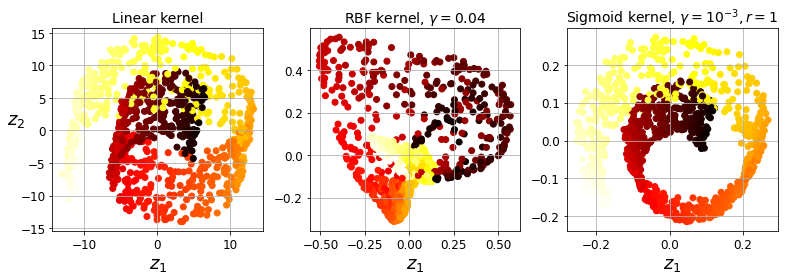

In [59]:
lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True, n_jobs=-1)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True, n_jobs=-1)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True, n_jobs=-1)
y = t > 6.9
plt.figure(figsize=(11, 4))
for subplot, pca, title in (
        (131, lin_pca, "Linear kernel"),
        (132, rbf_pca, "RBF kernel, $\gamma=0.04$"),
        (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")
):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    plt.subplot(subplot)
    # plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    # plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
save_fig("kernel_pca_plot")
plt.show()

**<커널 PCA와 재구성 원상 오차>**

그림 저장 preimage_plot


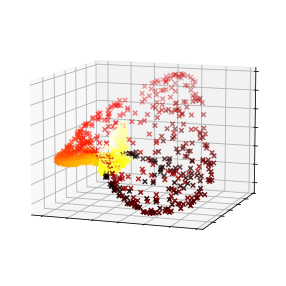

In [60]:
plt.figure(figsize=(6, 5))
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)
ax = plt.subplot(111, projection="3d")
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker='x')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
save_fig("preimage_plot", tight_layout=False)
plt.show()

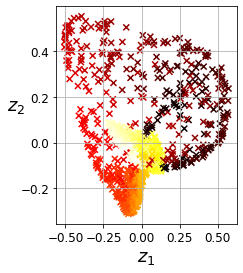

In [61]:
X_reduced = rbf_pca.fit_transform(X)
plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker='x')
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## 커널 선택과 하이퍼파라미터 튜닝

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

clf = Pipeline([("kpca", KernelPCA(n_components=2, n_jobs=-1)), ("log_reg", LogisticRegression(n_jobs=-1))])
param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10), "kpca__kernel": ["rbf", "sigmoid"]}]
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca',
                                        KernelPCA(n_components=2, n_jobs=-1)),
                                       ('log_reg',
                                        LogisticRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [63]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03666666666666667, 'kpca__kernel': 'rbf'}


In [64]:
rbf_pca = KernelPCA(
    n_components=2,
    kernel=grid_search.best_params_["kpca__kernel"],
    gamma=grid_search.best_params_["kpca__gamma"],
    fit_inverse_transform=True,
    n_jobs=-1
)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [65]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

28.812989943746988

# LLE

In [66]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2)

In [67]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=10, n_jobs=-1)
X_reduced = lle.fit_transform(X)

그림 저장 lle_unrolling_plot


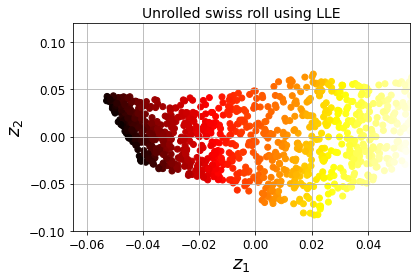

In [68]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
save_fig("lle_unrolling_plot")
plt.show()

# 다른 차원 축소 기법

In [69]:
from sklearn.manifold import MDS

mds = MDS(n_jobs=-1)
X_reduced_mds = mds.fit_transform(X)

In [70]:
from sklearn.manifold import Isomap

isomap = Isomap(n_jobs=-1)
X_reduced_isomap = isomap.fit_transform(X)

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_jobs=-1)
X_reduced_tsne = tsne.fit_transform(X)

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

**<여러 가지 기법을 사용해 스위스 롤을 2D로 축소하기>**

그림 저장 other_dim_reduction_plot


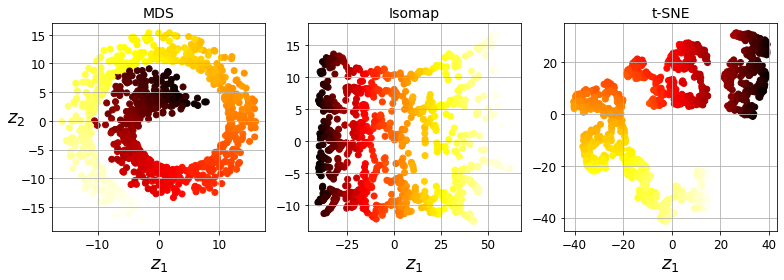

In [73]:
titles = ["MDS", "Isomap", "t-SNE"]
plt.figure(figsize=(11, 4))
for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
save_fig("other_dim_reduction_plot")
plt.show()

# 연습

## 1.

*MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할한다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용이다).*

앞서 로드한 MNIST 데이터셋을 사용한다.

In [74]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]
X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가한다.*

In [75]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_jobs=-1)

In [76]:
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [77]:
print(f"훈련 시간: {t1 - t0:.2f}s")

훈련 시간: 6.12s


In [78]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9701

*그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소한다.*

In [79]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인한다. 훈련 속도가 더 빨라질까?*

In [80]:
rnd_clf2 = RandomForestClassifier(n_jobs=-1)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [81]:
print(f"훈련 시간: {t1 - t0:.2f}s")

훈련 시간: 12.16s


이런! 훈련이 두 배 이상 느려졌다! 어떻게 이럴 수 있을까? 차원 축소는 언제나 훈련 시간을 줄여 주지는 못한다. 데이터셋, 모델, 훈련 알고리즘에 따라 달라진다. 위에 있는 `manifold_decision_boundary_plot*` 그래프를 참고한다. 랜덤 포레스트 분류기 대신 소프트맥스 분류기를 적용하면 PCA를 사용해서 훈련 시간을 3배나 줄일 수 있다. 잠시 후에 실제로 한 번 해 보겠다. 하지만 먼저 새로운 랜덤 포레스트 분류기의 정확도를 확인해 보자.

*이제 테스트 세트에서 이 분류기를 평가해 본다. 이전 분류기와 비교해서 어떨까?*

In [82]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9496

차원 축소를 했을 때 유용한 정보를 일부 잃었기 때문에 성능이 조금 감소되는 것이 일반적이다. 그렇지만 이 경우에는 성능 감소가 좀 심각한 것 같다. PCA가 별로 도움이 되지 않는다. 훈련 시간도 느려지고 성능도 감소했다. :(

소프트맥스 회귀를 사용하면 도움이 되는지 확인해 보겠다:

In [83]:
log_clf = LogisticRegression(multi_class="multinomial", n_jobs=-1)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [84]:
print(f"훈련 시간: {t1 - t0:.2f}s")

훈련 시간: 35.42s


In [85]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

좋다. 소프트맥스 회귀는 랜덤 포레스트 분류기보다 이 데이터셋에서 훈련하는 데 더 많은 시간이 걸리고 테스트 세트에서의 성능도 더 나쁘다. 하지만 지금 관심 사항은 아니다. PCA가 소프트맥스 회귀에 얼마나 도움이 되는지가 궁금하다. 축소된 데이터셋에 소프트맥스 회귀 모델을 훈련시켜 보겠다:

In [86]:
log_clf2 = LogisticRegression(multi_class="multinomial", n_jobs=-1)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [87]:
print(f"훈련 시간: {t1 - t0:.2f}s")

훈련 시간: 8.85s


와우! 차원 축소가 속도를 2배 이상 빠르게 만들었다. :) 모델의 정확도를 확인해 보겠다:

In [88]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

성능이 조금 감소되었지만 애플리케이션에 따라서 2배 이상의 속도 향상에 대한 댓가로 적절한 것 같다.

여기서 알 수 있는 것: PCA는 속도를 아주 빠르게 만들어 주지만 항상 그런 것은 아니다!

## 2.

*t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려 보자. 이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있다.*

앞서 로드한 MNIST 데이터셋을 사용한다.

전체 60,000개의 이미지에 차원 축소를 하면 매우 오랜 시간이 걸리므로 10,000개의 이미지만 무작위로 선택하여 사용하겠다:

In [89]:
m = 10000
idx = np.random.permutation(60000)[:m]
X = mnist["data"][idx]
y = mnist["target"][idx]

이제 t-SNE를 사용해 2D로 차원을 축소해 그래프로 나타낸다:

In [90]:
tsne = TSNE(n_jobs=-1)
X_reduced = tsne.fit_transform(X)

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


산점도를 그리기 위해 맷플롯립의 `scatter()` 함수를 사용한다. 각 숫자마다 다른 색깔을 사용한다:

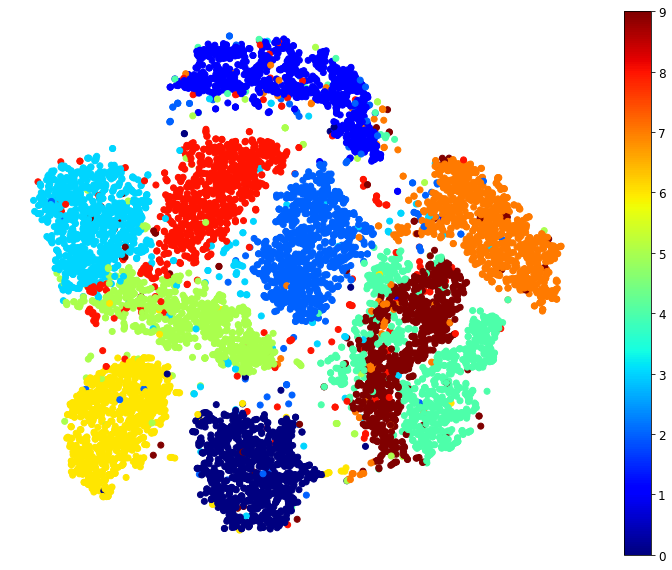

In [91]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis("off")
plt.colorbar()
plt.show()

아름답다. :) 이 그래프는 어떤 숫자가 다른 것과 구분이 쉬운지 알려 준다(가령, 0, 6, 8이 잘 구분되어 있다). 그리고 어떤 숫자가 구분이 어려운지 알려 준다(가령, 4, 9, 5, 3 등이다).

많이 겹쳐진 것 같은 숫자 2, 3, 5에 집중해 보겠다.

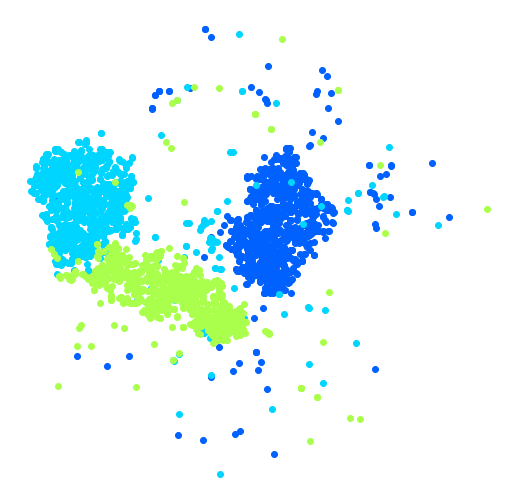

In [92]:
plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis("off")
plt.show()

이 3개의 숫자에 t-SNE를 실행시켜 더 나은 이미지를 만들 수 있는지 보겠다:

In [93]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]
tsne_subset = TSNE(n_jobs=-1)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


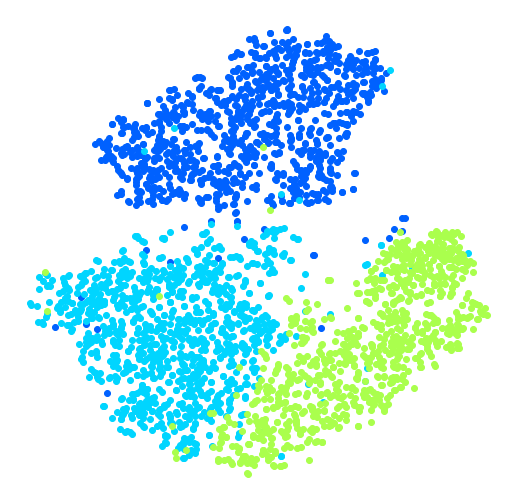

In [94]:
plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis("off")
plt.show()

훨씬 좋다. 이제 군집이 덜 겹쳐졌다. 하지만 숫자 3이 여러 군데 흩어져 있다. 각 군집에 숫자를 몇 개씩 나타내면 이런 이유를 훨씬 이해하기 좋다. 그렇게 한 번 해 본다.

*또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있다(모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그린다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것이다.*

(위에 있는 산점도와 비슷하게) 산점도와 색깔 있는 숫자를 쓰기 위해 `plot_digits()` 함수를 만든다. 이 숫자 사이의 거리가 최소가 되도록 한다. 숫자 이미지가 있다면 대신 이를 사용한다. 이 코드는 사이킷런의 훌륭한 데모([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), 데이터셋은 다르다)를 참고했다.

In [95]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만든다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만든다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정한다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽다.
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져온다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(
                    image_coord[0],
                    image_coord[1],
                    str(int(y[index])),
                    color=cmap(y[index] / 9),
                    fontdict={"weight": "bold", "size": 16}
                )
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

시작해 보자! 먼저 색깔이 입혀진 숫자를 써 보겠다:

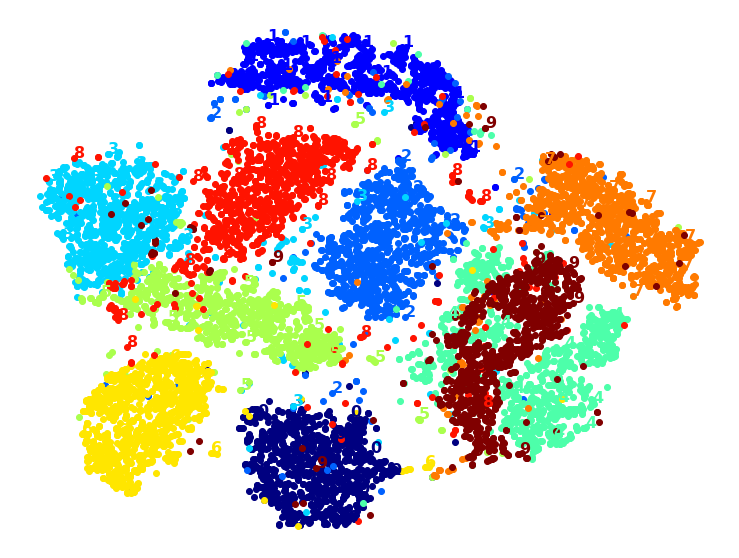

In [96]:
plot_digits(X_reduced, y)

꽤 좋다. 하지만 아름답지는 않다. 숫자 이미지를 사용해 보겠다:

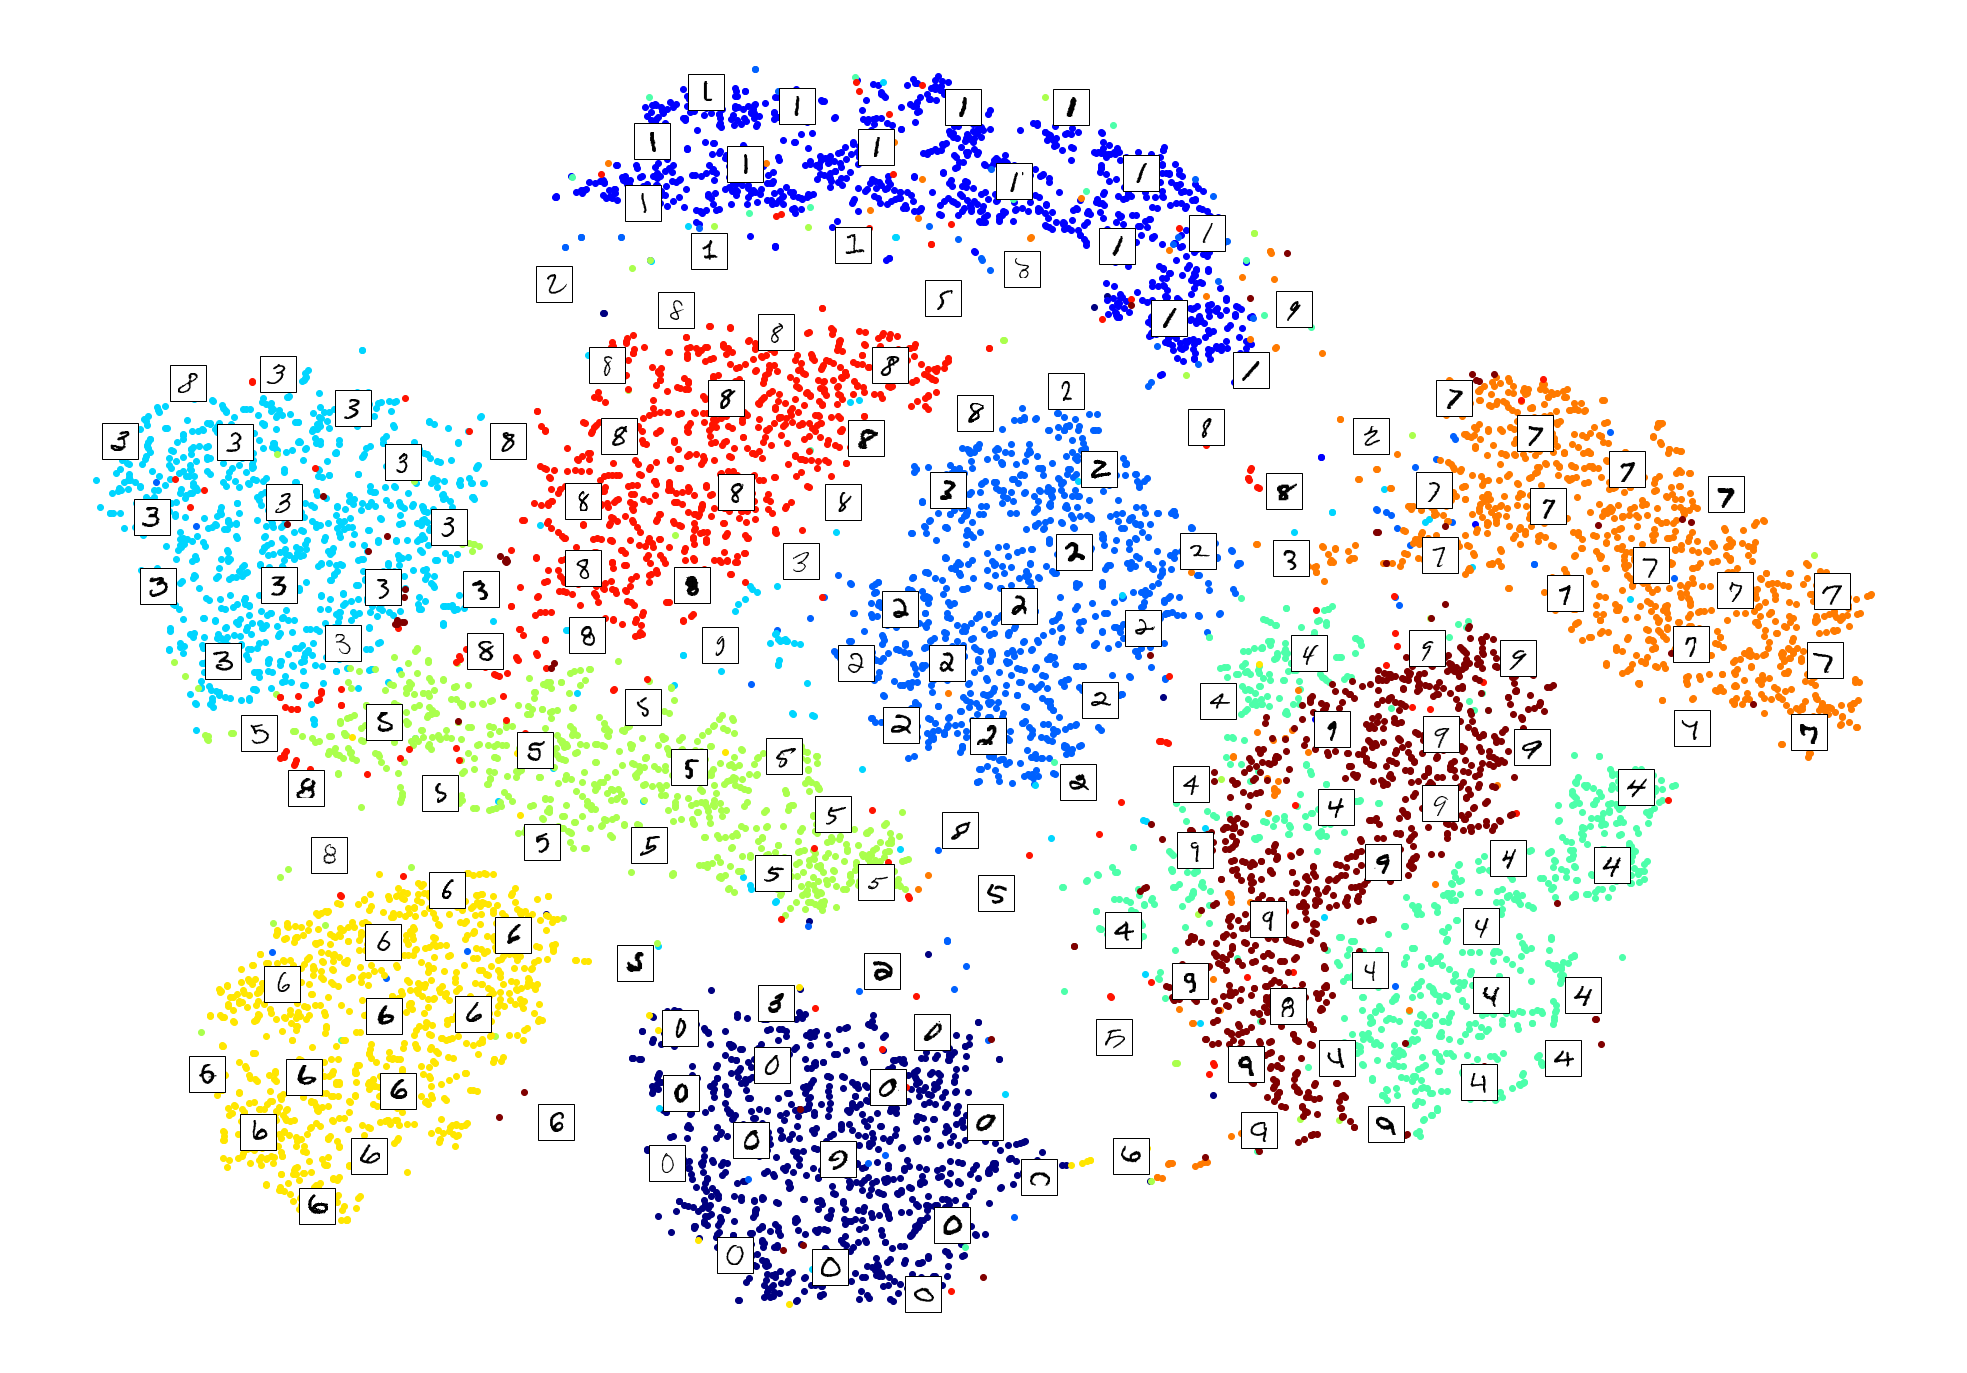

In [97]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

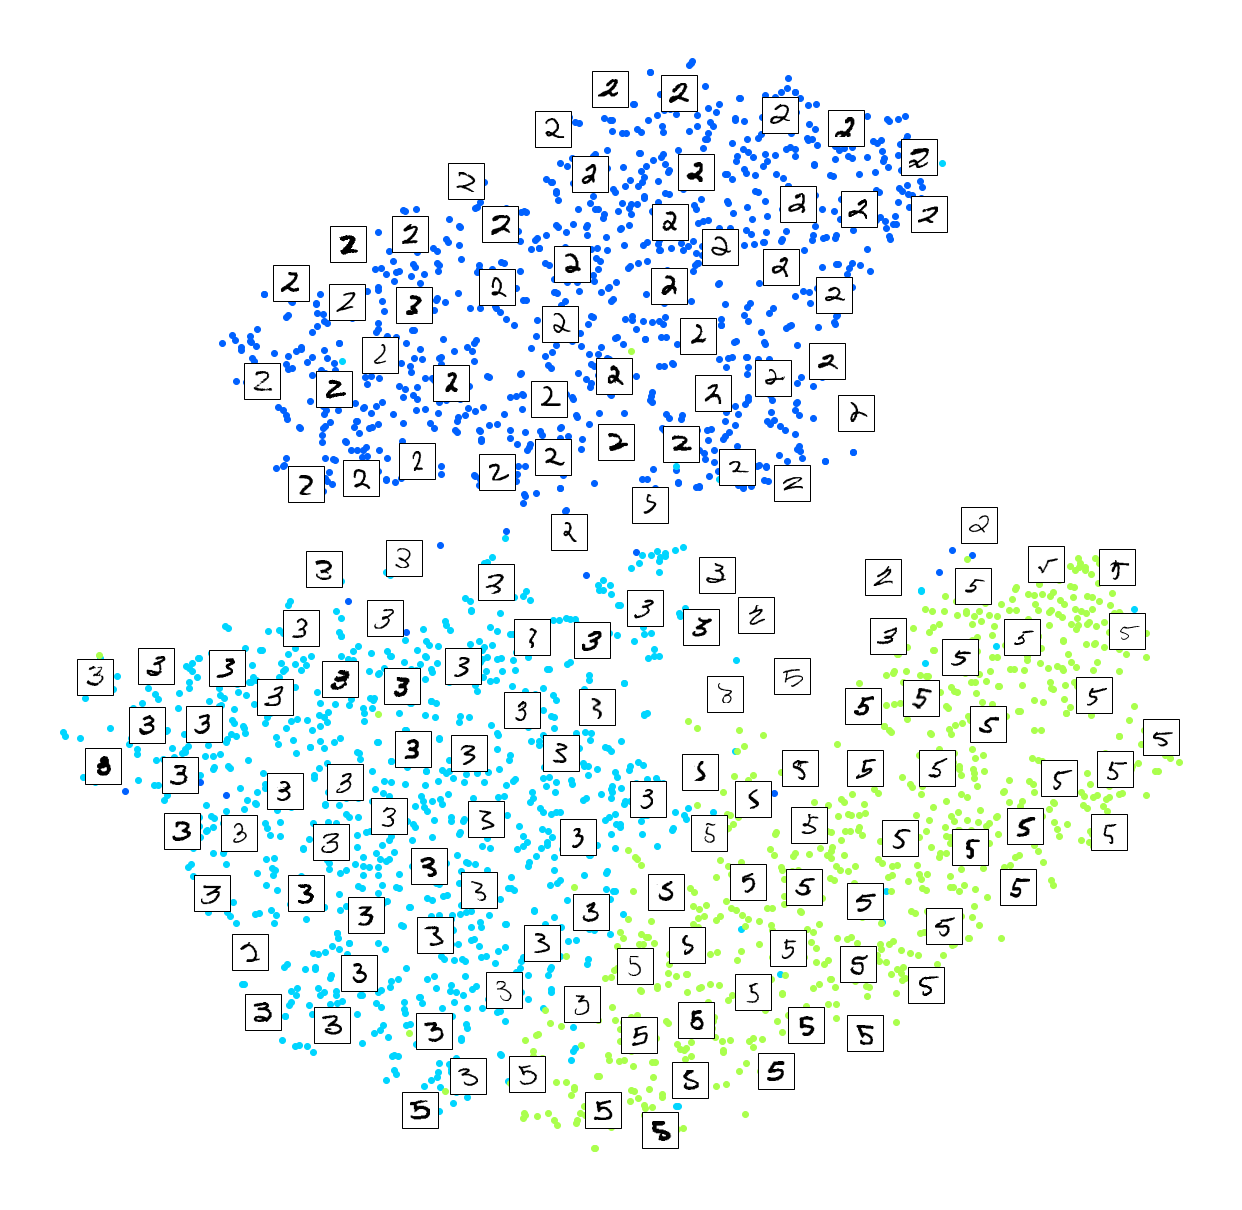

In [98]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해 보고 시각화 결과를 비교해 보자.*

PCA부터 시작해 본다. 얼마나 오래 걸리는지도 재어 보겠다:

PCA 시간: 0.2s.


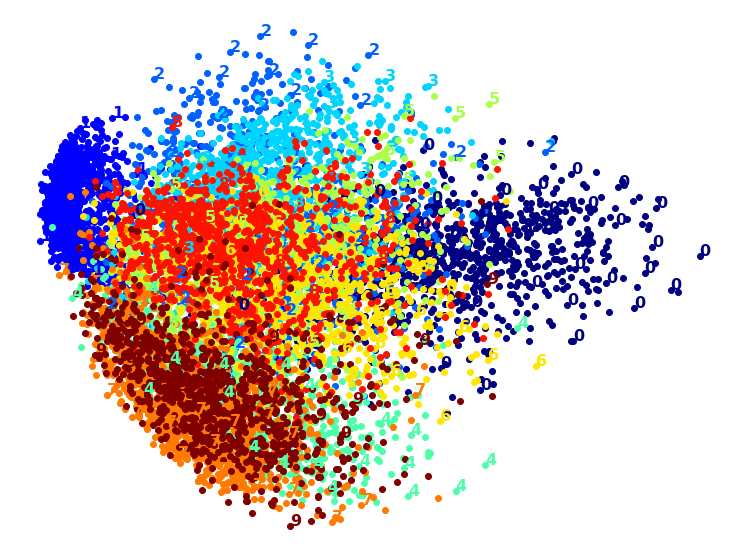

In [99]:
t0 = time.time()
X_pca_reduced = PCA(n_components=2).fit_transform(X)
t1 = time.time()
print(f"PCA 시간: {t1 - t0:.1f}s.")
plot_digits(X_pca_reduced, y)
plt.show()

와우, PCA가 아주 빠르다! 몇 개의 군집이 보이지만 너무 겹쳐져 있다. LLE를 사용해 본다:

LLE 시간: 44.7s.


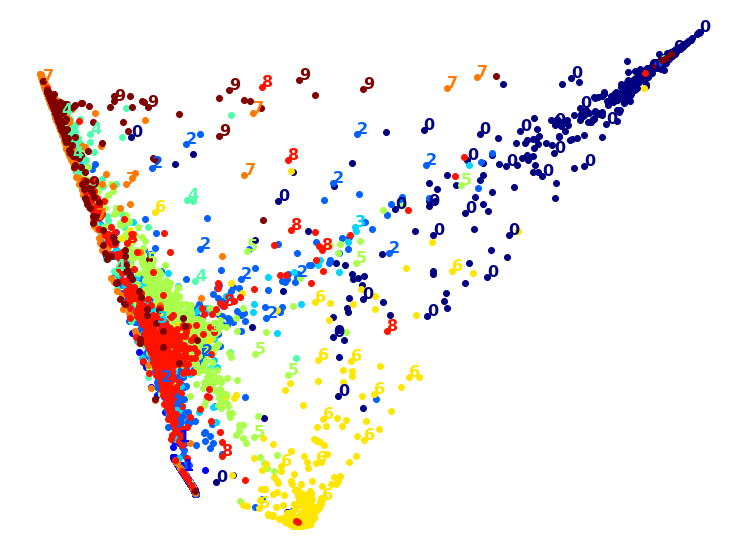

In [100]:
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_jobs=-1).fit_transform(X)
t1 = time.time()
print(f"LLE 시간: {t1 - t0:.1f}s.")
plot_digits(X_lle_reduced, y)
plt.show()

시간이 좀 걸리고 결과도 아주 좋지 않다. 분산의 95%를 보존하도록 먼저 PCA를 적용하면 어떻게 되는지 보겠다:

PCA+LLE 시간: 47.9s.


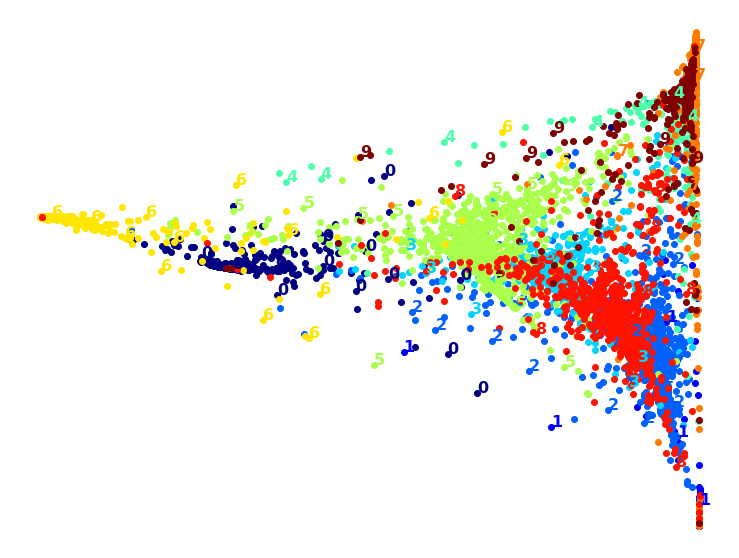

In [101]:
pca_lle = Pipeline([("pca", PCA(n_components=0.95)), ("lle", LocallyLinearEmbedding(n_jobs=-1))])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print(f"PCA+LLE 시간: {t1 - t0:.1f}s.")
plot_digits(X_pca_lle_reduced, y)
plt.show()

결과는 비슷하고 걸린 시간도 비슷하다.

MDS를 시도해 본다. 10,000개 샘플을 적용하면 이 알고리즘은 너무 오래걸리므로 2,000개만 시도해 보겠다:

MDS 시간 52.0s (on just 2,000 MNIST images instead of 10,000).


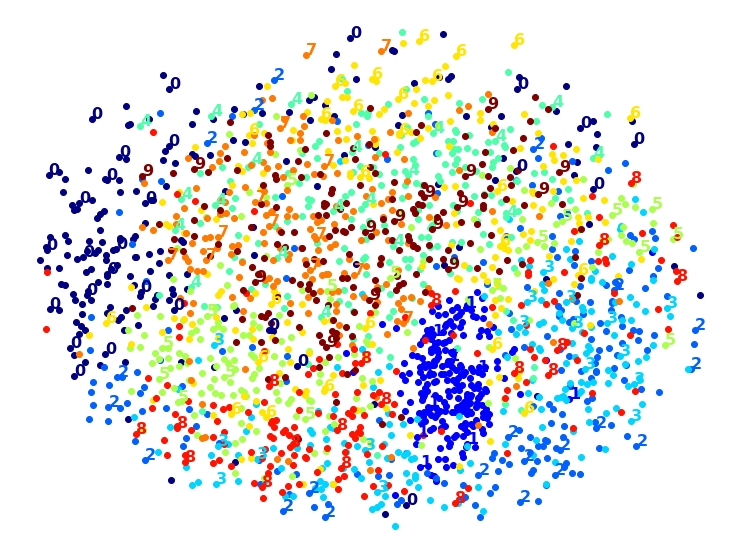

In [102]:
m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_jobs=-1).fit_transform(X[:m])
t1 = time.time()
print(f"MDS 시간 {t1 - t0:.1f}s (on just 2,000 MNIST images instead of 10,000).")
plot_digits(X_mds_reduced, y[:m])
plt.show()

아 이건 좋지 않아 보인다. 모든 군집이 너무 중복되어 있다. 먼저 PCA를 적용하면 빨라질까?

PCA+MDS 시간 53.1s (on 2,000 MNIST images).


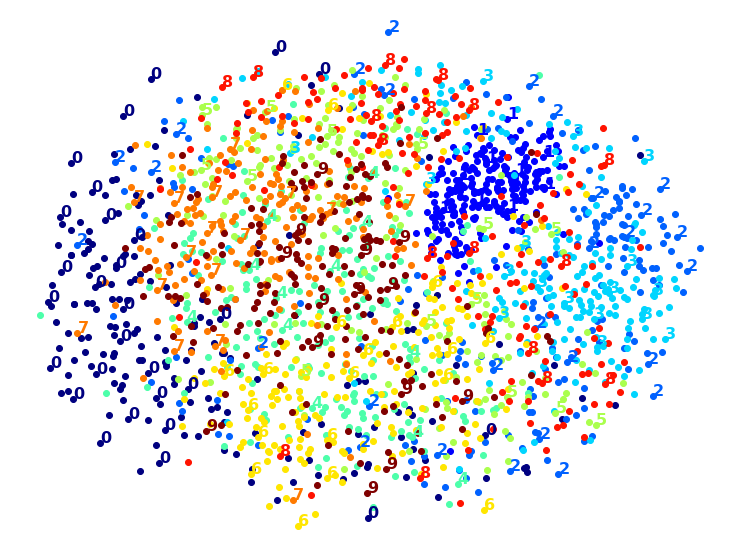

In [103]:
pca_mds = Pipeline([("pca", PCA(n_components=0.95)), ("mds", MDS(n_jobs=-1))])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간 {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

같은 결과에 속도도 동일하다. PCA가 도움이 되지 않는다.

LDA를 시도해 본다:

LDA 시간 1.9s.


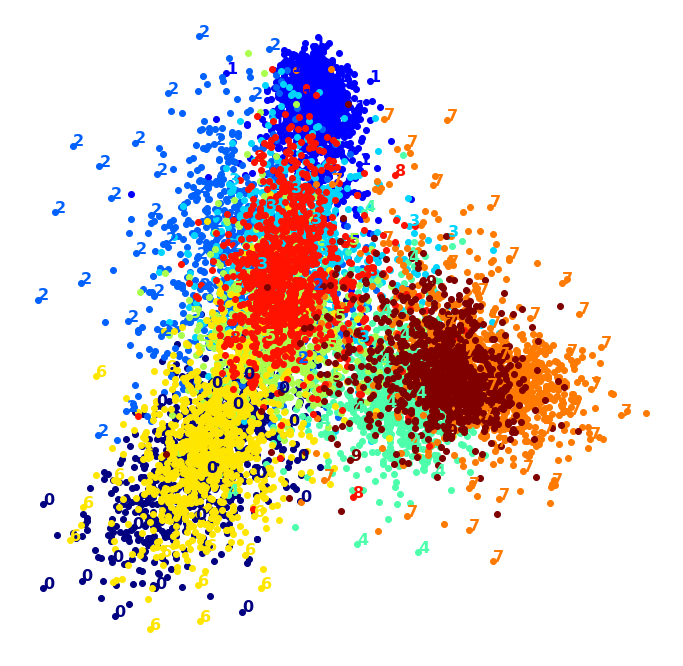

In [104]:
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print(f"LDA 시간 {t1 - t0:.1f}s.")
plot_digits(X_lda_reduced, y, figsize=(12, 12))
plt.show()

매우 빨라 처음엔 괜찮아 보이지만 자세히 보면 몇 개의 군집이 심각하게 중복되어 있다.

아마 이 비교에서 t-SNE가 승자 같다. 시간을 재어 보진 않았으니 한 번 해 본다:

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE 시간 32.1s.


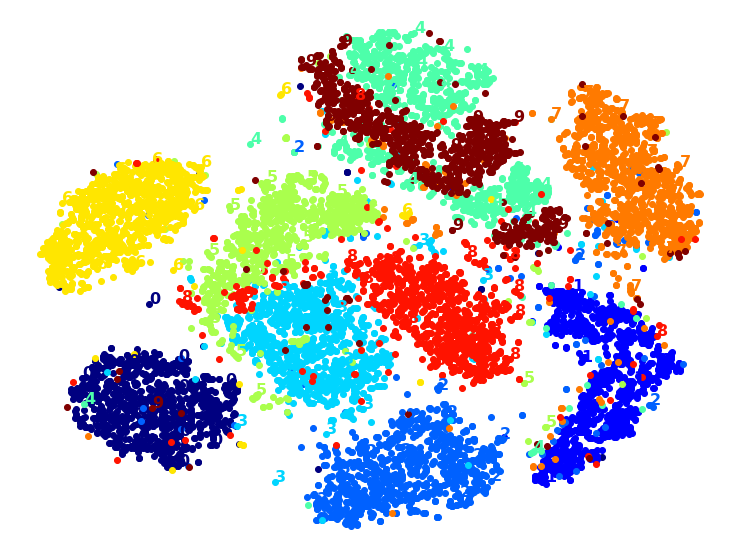

In [105]:
t0 = time.time()
X_tsne_reduced = TSNE(n_jobs=-1).fit_transform(X)
t1 = time.time()
print(f"t-SNE 시간 {t1 - t0:.1f}s.")
plot_digits(X_tsne_reduced, y)
plt.show()

LLE보다 조금 빠르다. 하지만 MDS보단 훨씬 빠르고 결과물도 아주 좋다. PCA가 속도를 높여 줄 수 있는지 확인해 보겠다:

C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


PCA+t-SNE 시간 35.8s.


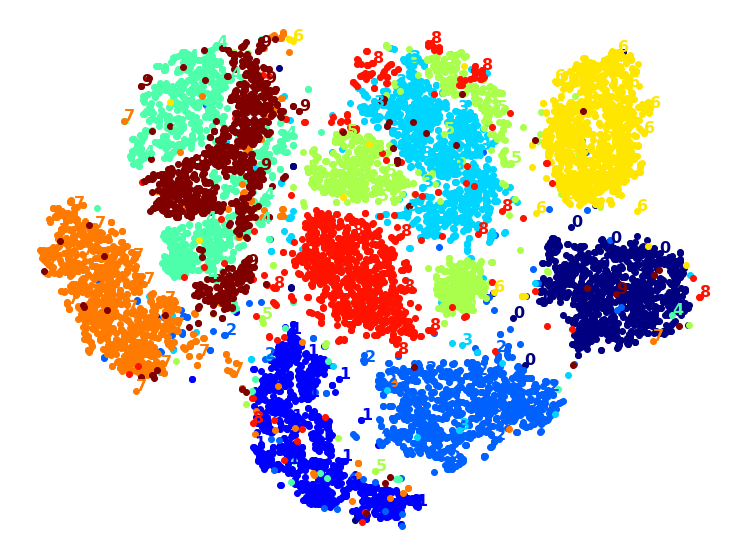

In [106]:
pca_tsne = Pipeline([("pca", PCA(n_components=0.95)), ("tsne", TSNE(n_jobs=-1))])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print(f"PCA+t-SNE 시간 {t1 - t0:.1f}s.")
plot_digits(X_pca_tsne_reduced, y)
plt.show()

결과물에 영향을 미치지는 않았지만 속도가 조금 더 느리다. t-SNE를 단독으로 쓰는 것이 제일 좋다!